# Behavior Cloning Project
The objectives of this project are to capture training data using a simulator and clone the users steering angle behavior in the provided simulator

In [1]:
import csv
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout, Cropping2D, Activation
import keras.backend.tensorflow_backend as K
from keras.optimizers import SGD, Adam, RMSprop
import keras
from keras.models import load_model


# If set to false Train from scratch else train 
# on small data that augments model
augment  = True

Using TensorFlow backend.


In [2]:
new_size_col,new_size_row = 160, 80

labels = []
if augment is True:
    log_path = '../data_aug/driving_log.csv'
else:
    log_path = '../data_raw/driving_log.csv'
with open(log_path) as file:
    for label in file:
        labels.append(label)

In [3]:
# Augment image by randomly scaling Brightnesss
def brightness_random(input_image):
    # Convert image to HSV so that brightness can 
    # be adjusted by just the Value channel
    output_image = cv2.cvtColor(input_image,cv2.COLOR_RGB2HSV)
   
    # Draw a random Value so that brightness can be 
    # adjusted from .33 5o 1.33 of original Value
    random_value = np.random.uniform(0.33,1.33)
    
    # Change value while retaining hue and saturation
    output_image[:,:,2] = output_image[:,:,2]*random_value
    
    
    # Reconvert to RGB 
    output_image = cv2.cvtColor(output_image,cv2.COLOR_HSV2RGB)
    
    return output_image


In [4]:
# Augment image by translating in both axes by random values

def translate_random(input_image,steering_value):
    # Translation max range is 1/4th of height
    translation_max = 80
    
    translation = np.random.uniform(-0.5,0.5)
    x_translation = translation_max*translation
    
    new_steering = steering_value + translation*0.1
   
    transformation_matrix = np.float32([[1,0,x_translation],
                                        [0,1,0]])
    output_image = cv2.warpAffine(input_image,transformation_matrix,(160,80))
    
    return output_image,new_steering

In [5]:
def rescaleImage(image):
    shape = image.shape
    image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)    
    #image = image/255.-.5
    return image

In [6]:
def preprocess_image_for_training(data,label):
    steering = label
    image = cv2.imread(data)
    image = rescaleImage(image)
    image = np.array(brightness_random(image))
#     image,steering = translate_random(image,steering)
    
    # Only flip center images randomly
    to_flip = np.random.randint(0,2)
    if 'center' in data and to_flip==1:
        image = cv2.flip(image,1)
        steering = -1.0*steering
    
    return image,steering

In [7]:
def preprocess_image_for_validation(data):
    image = cv2.imread(data) 
    return np.array(rescaleImage(image))


def validation_generator_function(features,labels):
    while 1:
        for i in range(len(features)):
            data = features[i]
            label = labels[i]
            x = preprocess_image_for_validation(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = np.array([[label]])
            
            yield x, y
            

In [8]:
def training_generator_function(data,labels,batch_size = 32):
    
    batch_data = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_labels = np.zeros(batch_size)
    while 1:
        for i in range(batch_size):
            random_index = np.random.randint(len(data))
            data_point = data[random_index]
            label_point = labels[random_index]
            x,y = preprocess_image_for_training(data_point,label_point)
            batch_data[i] = x
            batch_labels[i] = y
        yield batch_data, batch_labels

In [9]:
features = []
values = []

index = 0 
for label in labels[1:]:
    #-17,-9,-1
    center = label.split('/')[-17].split(',')[0]
    left = label.split('/')[-9].split(',')[0]
    right = label.split('/')[-1].split(',')[0]
    if augment is False:
        path = '../data/IMG/'
    else:
        path = '../data_aug/IMG/'
    
    image_center = path + center
    image_left = path + left
    image_right =  path + right 
    
    
    steering_value = float(label.split('/')[-1].split(',')[1])
    steering_compensation = 0.10 + (steering_value*steering_value)/0.5
    throttle_value = float(label.split('/')[-1].split(',')[4])

    if (throttle_value <= 7.5):
        continue

    steering_compensated_left = steering_value + steering_compensation
    steering_compensated_right = steering_value - steering_compensation
    
    features.append(image_left)
    values.append(steering_compensated_left)

    features.append(image_right)
    values.append(steering_compensated_right)  

    features.append(image_center)
    values.append(steering_value)

In [10]:
print (len(values))

1449


In [11]:
X_train = np.array( features )

y_train = np.array( values )


validation_generator = validation_generator_function(X_train, y_train)

In [12]:

if augment is False:    
    bc_model = Sequential()
    bc_model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(new_size_row,new_size_col,3)))
    bc_model.add(Cropping2D(cropping=((8,8), (0,0))))

    bc_model.add(Conv2D(24, 5,5, subsample = (2,2), activation='relu'))
    bc_model.add(Conv2D(36, 5,5, subsample = (2,2), activation='relu' ))
    bc_model.add(Conv2D(48, 5,5, subsample = (2,2), activation='relu'))
    bc_model.add(Conv2D(64,3,3, activation='relu'))
    bc_model.add(Conv2D(64,3,3, activation='relu'))
    bc_model.add(Flatten())
    bc_model.add(Dense(100))
    bc_model.add(Dense(50))
    bc_model.add(Dense(10))
    bc_model.add(Dense(1))
else:
    bc_model = model = load_model('model.h5')
bc_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 80, 160, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 64, 160, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 30, 78, 24)    1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 13, 37, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

In [13]:
bc_model.compile(loss='mse',optimizer='adam')
batch_size = 128
num_samples = int(len(X_train)/batch_size)*batch_size

filepath="model-{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]
history_object = bc_model.fit_generator(training_generator_function(X_train,y_train, batch_size),
                    samples_per_epoch= num_samples,
                    nb_epoch=10,
                    validation_data=validation_generator,
                    nb_val_samples = int(num_samples/5),
                    verbose=1,
                    callbacks=callbacks_list)



# bc_model.save('simple_model.h5')

Epoch 1/10
1408/1408 [==============================] - 2s - loss: 0.2093 - val_loss: 0.1980
Epoch 2/10
1408/1408 [==============================] - 1s - loss: 0.1769 - val_loss: 0.1148
Epoch 3/10
1408/1408 [==============================] - 1s - loss: 0.1374 - val_loss: 0.0436
Epoch 4/10
1408/1408 [==============================] - 1s - loss: 0.1248 - val_loss: 0.1447
Epoch 5/10
1408/1408 [==============================] - 1s - loss: 0.1247 - val_loss: 0.0517
Epoch 6/10
1408/1408 [==============================] - 1s - loss: 0.1021 - val_loss: 0.0775
Epoch 7/10
1408/1408 [==============================] - 1s - loss: 0.0931 - val_loss: 0.0785
Epoch 8/10
1408/1408 [==============================] - 1s - loss: 0.0795 - val_loss: 0.0288
Epoch 9/10
1408/1408 [==============================] - 1s - loss: 0.0751 - val_loss: 0.1310
Epoch 10/10
1408/1408 [==============================] - 1s - loss: 0.0788 - val_loss: 0.0266


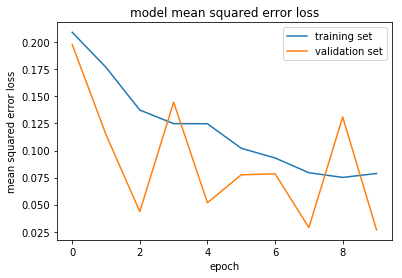

In [14]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()